# Week 10

Joshua Burden  
DSC530 Week 9
Bellevue University  
Catherine Williams  
08/08/2022

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT7

In [76]:
from __future__ import print_function, division

from os.path import basename, exists

%matplotlib inline




def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/1995FemRespData.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz")





Downloaded 2006_2010_FemResp.dat.gz


In [77]:
import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot
import nsfg

import nsfg

preg = nsfg.ReadFemPreg()
complete = preg.query('outcome in [1, 3, 4]').prglngth
cdf = thinkstats2.Cdf(complete, label='cdf')

import survival

In [78]:
def MakeSurvivalFromCdf(cdf, label=''):
    """Makes a survival function based on a CDF.

    cdf: Cdf
    
    returns: SurvivalFunction
    """
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)
sf = MakeSurvivalFromCdf(cdf, label='survival')

# Excerise  Pages 180-181: 13-1 
In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [84]:
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [85]:
resp6 = nsfg.ReadFemResp()
resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6['agemarry'] = (resp6.cmmarrhx - resp6.cmbirth) / 12.0
resp6['age'] = (resp6.cmintvw - resp6.cmbirth) / 12.0
omplete = resp6[resp6.evrmarry==1].agemarry.dropna()
ongoing = resp6[resp6.evrmarry==0].age

In [86]:
resp5 = survival.ReadFemResp1995()
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

In [87]:
CleanData(resp6)
married6 = resp6[resp6.evrmarry==1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry==1]

In [88]:
# plot divorce curves on resampled data

def ResampleDivorceCurve(resps):

    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color='#225EA8', alpha=0.1)

    thinkplot.Show(xlabel='years',
                   axis=[0, 28, 0, 1])

In [89]:
# plots divorce curves on birth cohort

def ResampleDivorceCurveByDecade(resps):
 
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel='Years',
                     ylabel='Fraction undivorced',
                     axis=[0, 28, 0, 1])

In [90]:
# Decade and plots suvival curve

def EstimateSurvivalByDecade(groups, **options):

    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)
def EstimateSurvival(resp):

    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

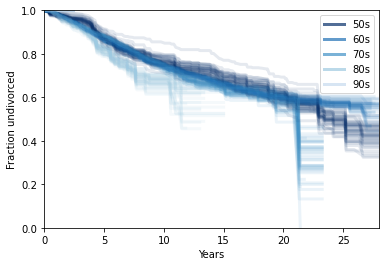

In [91]:
ResampleDivorceCurveByDecade([married6, married7])